# IS403.N22.HTCL
```python
Team 16
```
**SỬ DỤNG ĐỂ TÍNH TOÁN BỘ DỮ LIỆU GIÁ BẠC (19/05/2018 ĐẾN 19/05/2023)**
- Tỷ lệ tính toán Train Data: 60% Dataset
- Tỷ lệ tính toán Test Data: 30% Dataset
- Tỷ lệ tính toán Validation Data: 10% Dataset

In [1]:
#Import các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn import preprocessing
from keras.layers import Conv1D,Flatten,MaxPooling1D,Bidirectional,LSTM,Dropout,TimeDistributed
from keras.layers import Dense,GlobalAveragePooling2D
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error,mean_squared_error,mean_absolute_error

In [2]:
#Đọc file dữ liệu và xem dữ liệu
df = pd.read_csv('../SilverData.csv',parse_dates=True)
df

,Ngày,Lần cuối,Mở,Cao,Thấp,KL
0,21/5/2018,16.520,16.430,16.535,16.280,63.89K
1,22/5/2018,16.575,16.530,16.700,16.465,73.53K
2,23/5/2018,16.405,16.555,16.600,16.330,89.46K
3,24/5/2018,16.687,16.475,16.715,16.420,91.02K
4,25/5/2018,16.546,16.690,16.740,16.500,72.71K
...,...,...,...,...,...,...
1275,15/5/2023,24.175,24.030,24.270,23.945,0.17K
1276,16/5/2023,23.783,24.115,24.115,23.710,0.18K
1277,17/5/2023,23.789,23.830,23.940,23.650,0.18K
1278,18/5/2023,23.523,23.840,23.840,23.380,0.35K


In [3]:
#Xem các dữ liệu cơ bản của cảc thuộc tính
df.describe()

,Lần cuối,Mở,Cao,Thấp
count,1280.000000,1280.000000,1280.000000,1280.000000
mean,20.414323,20.428459,20.685217,20.134988
std,4.325552,4.335049,4.437082,4.203927
min,11.772000,11.975000,12.330000,11.640000
25%,16.223000,16.252500,16.388750,16.080000
50%,20.350500,20.312500,20.762500,19.987500
75%,24.250750,24.251250,24.580000,23.872500
max,29.418000,29.235000,30.350000,28.155000


In [4]:
#Kiểm tra dữ liệu rỗng
df.isnull().sum()

Ngày         0
Lần cuối     0
Mở           0
Cao          0
Thấp         0
KL          28
dtype: int64

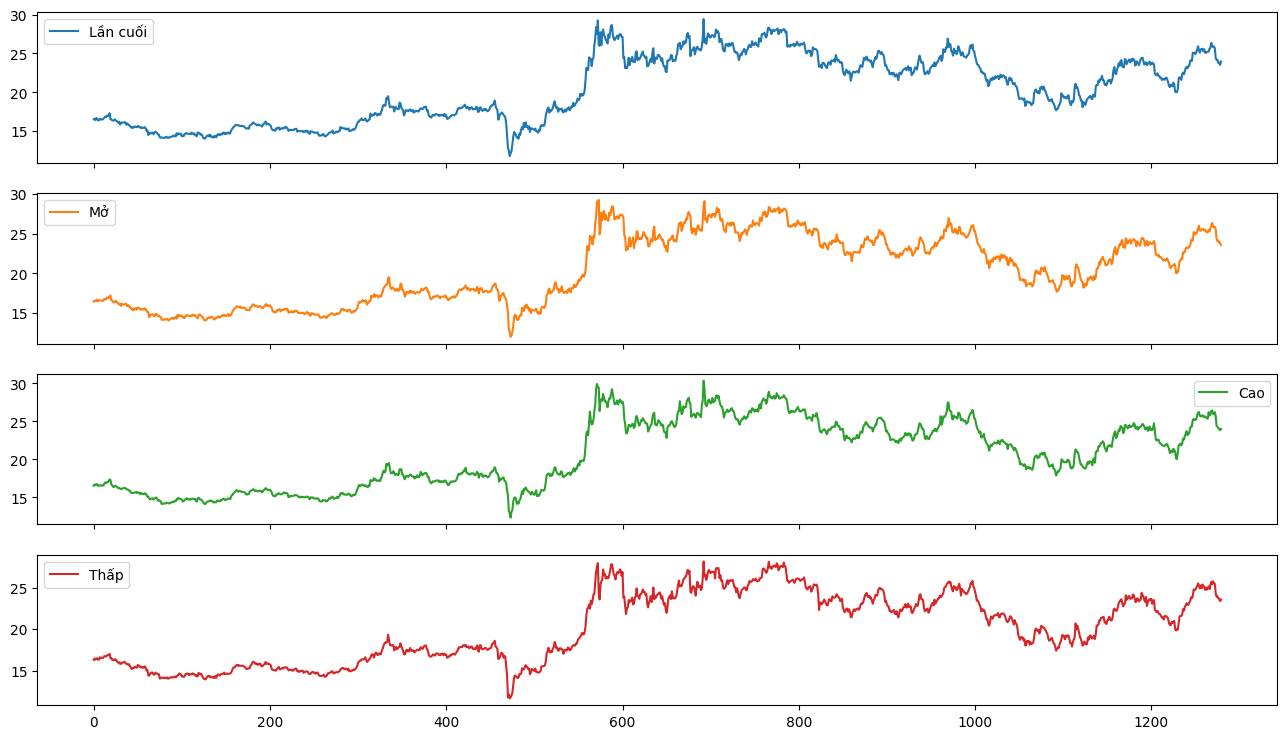

In [5]:
#Xem độ biến thiên của từng thuộc tính.
df.plot(legend=True,subplots=True, figsize = (16, 9))
plt.show()

In [6]:
#Chuyển dataset về cột Close để tiến hành tạo model
df = df[['Lần cuối']]
df

,Lần cuối
0,16.520
1,16.575
2,16.405
3,16.687
4,16.546
...,...
1275,24.175
1276,23.783
1277,23.789
1278,23.523


In [7]:
#Chia dữ liệu theo các tỷ lệ 7:2:1
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data_df = df[:train_size]
test_data_df = df[train_size:train_size+test_size]
val_data_df = df[train_size+test_size:]

In [8]:
# Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))

In [9]:
#Chia data đã Scaler
train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [10]:
#Tạo hàm create dataset
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX),np.array(dataY)


In [11]:
#Chia thành các tập X,y
time_step = 40
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)

In [12]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],1, X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],1 ,X_val.shape[1] , 1)


Vì thuật toán Hybird Neural Netword là sự kết hợp của các loại mạng neural khác nhau nên ở đây em kết hợp 2 mạng neural đã học là:
- Mạng neural hồi quy LSTM
- Mạng neural tích nhập CNN 

Cụ thể thì các lớp CNN được sử dụng để trích xuất đặc trưng từ dữ liệu không gian hoặc hình ảnh. Sau đó, các đặc trưng này được biến đổi và truyền vào các lớp LSTM. Các lớp LSTM có khả năng xử lý dữ liệu chuỗi thời gian và tạo ra dự đoán hoặc phân loại dựa trên thông tin này.

In [13]:
#Tiến hành tạo model
import tensorflow as tf
import tensorflow.keras.backend as K 
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError 
from tensorflow.keras.utils import plot_model

model = tf.keras.Sequential()

# CNN layers
model.add(TimeDistributed(Conv1D(256, kernel_size=3, activation='relu', input_shape=(None, 50 , 1))))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(128, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Conv1D(64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(2)))
model.add(TimeDistributed(Flatten()))

# LSTM layers
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(100, return_sequences=False)))
model.add(Dropout(0.5))

#Final layers
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse', 'mae'])

#fit model
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100,batch_size=50, verbose=1, shuffle =True)

Epoch 1/100
15/15 [==============================] - 22s 281ms/step - loss: 0.0984 - mse: 0.0984 - mae: 0.2327 - val_loss: 0.0318 - val_mse: 0.0318 - val_mae: 0.1580
Epoch 2/100
15/15 [==============================] - 1s 36ms/step - loss: 0.0209 - mse: 0.0209 - mae: 0.1070 - val_loss: 0.0061 - val_mse: 0.0061 - val_mae: 0.0614
Epoch 3/100
15/15 [==============================] - 1s 35ms/step - loss: 0.0116 - mse: 0.0116 - mae: 0.0724 - val_loss: 0.0058 - val_mse: 0.0058 - val_mae: 0.0607
Epoch 4/100
15/15 [==============================] - 1s 35ms/step - loss: 0.0101 - mse: 0.0101 - mae: 0.0667 - val_loss: 0.0061 - val_mse: 0.0061 - val_mae: 0.0635
Epoch 5/100
15/15 [==============================] - 0s 32ms/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0682 - val_loss: 0.0079 - val_mse: 0.0079 - val_mae: 0.0730
Epoch 6/100
15/15 [==============================] - 1s 35ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0681 - val_loss: 0.0069 - val_mse: 0.0069 - val_mae: 0.0671
Epoch 7/100
15

In [14]:
# Dự đoán

# Dự đoán train
y_pred_train=model.predict(X_train)
y_train=scaler.inverse_transform(y_train.reshape(-1,1))
y_pred_train=scaler.inverse_transform(y_pred_train.reshape(-1,1))
#Dự đoán Test
y_pred_test=model.predict(X_test)
y_test=scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_test=scaler.inverse_transform(y_pred_test.reshape(-1,1))
#Dự đoán Validation
y_pred_val=model.predict(X_val)
y_val=scaler.inverse_transform(y_val.reshape(-1,1))
y_pred_val=scaler.inverse_transform(y_pred_val.reshape(-1,1))

3/3 [==============================] - 0s 4ms/step


In [15]:
#Hàm visualize
def visualize(label ,pred, model_name):
  plt.figure(figsize=(12,8))
  plt.plot(label, label = 'Ground truth')
  plt.plot(pred, label='Predict')
  plt.title(model_name)
  plt.xlabel('Date')
  plt.ylabel('Closing Price')
  plt.legend()
  plt.show()

In [16]:
#Đánh giá 
def deviation(test, pred):
  rmse= np.sqrt(mean_squared_error(test,pred))
  print(f"RMSE: {rmse:.2f}")
  mape= mean_absolute_percentage_error(test,pred)
  print(f"MAPE: {mape*100:.2f}%")
  mae = mean_absolute_error(test, pred)
  print(f"MAE: {mae:.2f}")

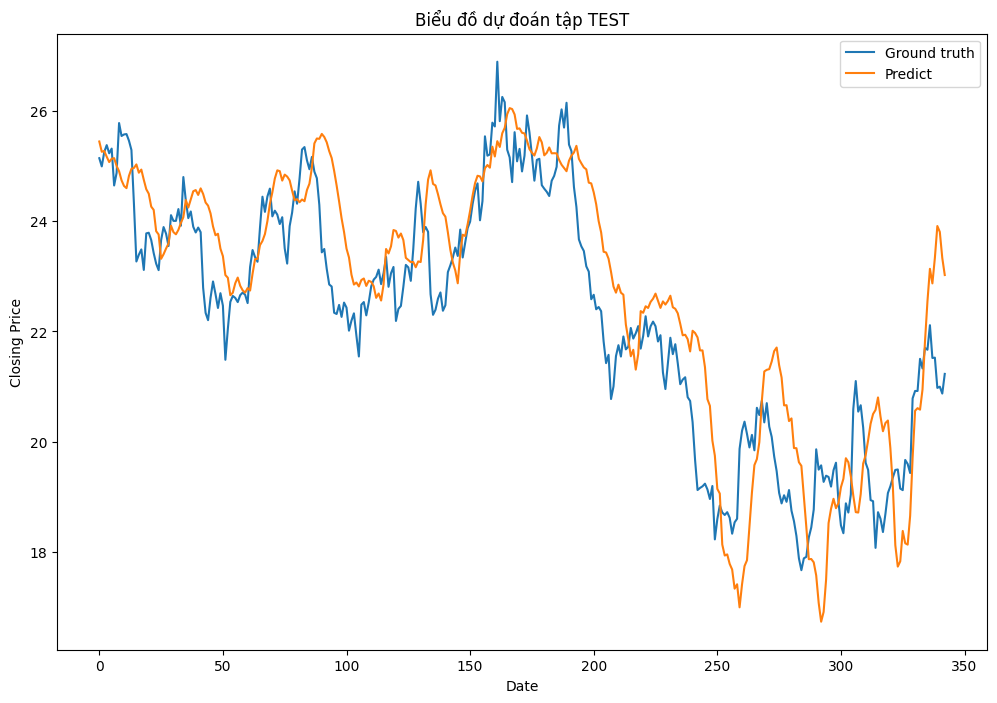

Đánh Giá tập TEST
RMSE: 1.19
MAPE: 4.48%
MAE: 0.96


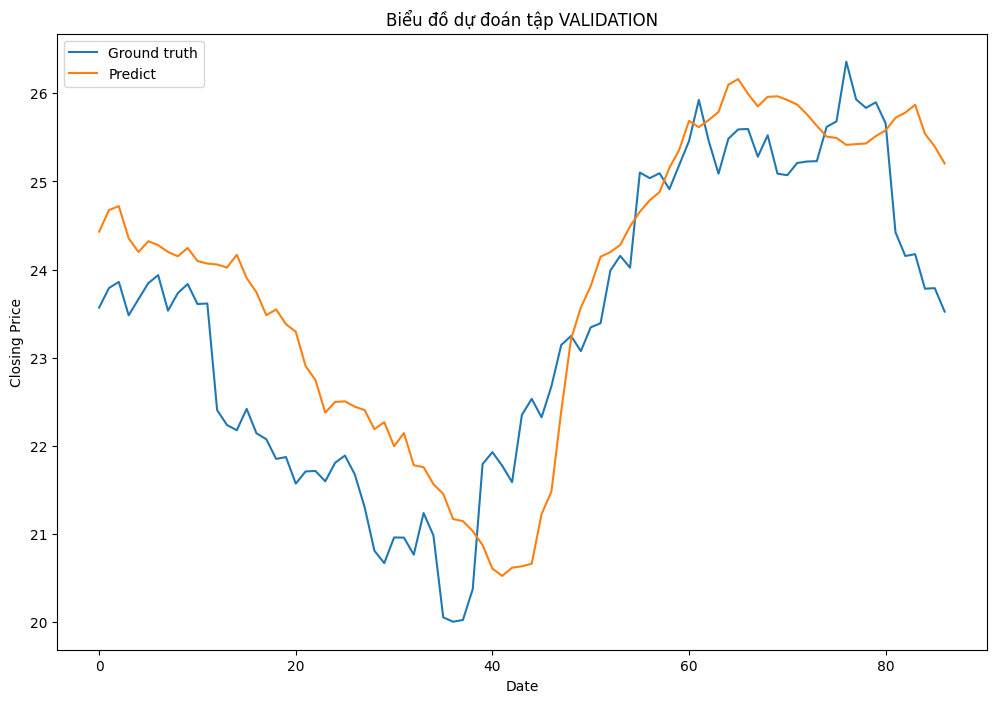

Đánh Giá tập VALIDATION
RMSE: 1.00
MAPE: 3.78%
MAE: 0.86


In [17]:
# visualize(y_train,y_pred_train,'Biểu đồ dự đoán tập TRAIN')
visualize(y_test,y_pred_test,'Biểu đồ dự đoán tập TEST')
print('Đánh Giá tập TEST')
deviation(y_test, y_pred_test)
visualize(y_val,y_pred_val,'Biểu đồ dự đoán tập VALIDATION')
print('Đánh Giá tập VALIDATION')
deviation(y_val, y_pred_val)

In [18]:
# #Dự đoán 30 ngày tiếp theo
# pred_next = np.array([])
  
# y_val=y_val[-time_step:].reshape(1,-1).reshape(1,time_step)
  
# for i in range(30):
#     y_pred_next = model.predict(y_val.reshape(1,-1).reshape(1,1,time_step,1))
#     y_val = np.append(y_val,y_pred_next[0])[1:]
#     pred_next = np.append(pred_next,y_pred_next[0])
    
# next30days_predict_inverse = pd.DataFrame(scaler.inverse_transform(pred_next.reshape(-1,1)))

#Dự đoán 30 ngày tiếp theo
pred_next = np.array([])
  
y_val_to_next=scaler.fit_transform(np.array(y_val[-time_step:].reshape(1,-1).reshape(1,time_step)).reshape(-1,1))
  
for i in range(30):
    y_pred_next = model.predict(y_val_to_next.reshape(1,-1).reshape(1,1,time_step,1))
    y_val_to_next = np.append(y_val_to_next,y_pred_next[0])[1:]
    pred_next = np.append(pred_next,y_pred_next[0])
    
next30days_predict_inverse = pd.DataFrame(scaler.inverse_transform(pred_next.reshape(-1,1)))



1/1 [==============================] - 0s 17ms/step


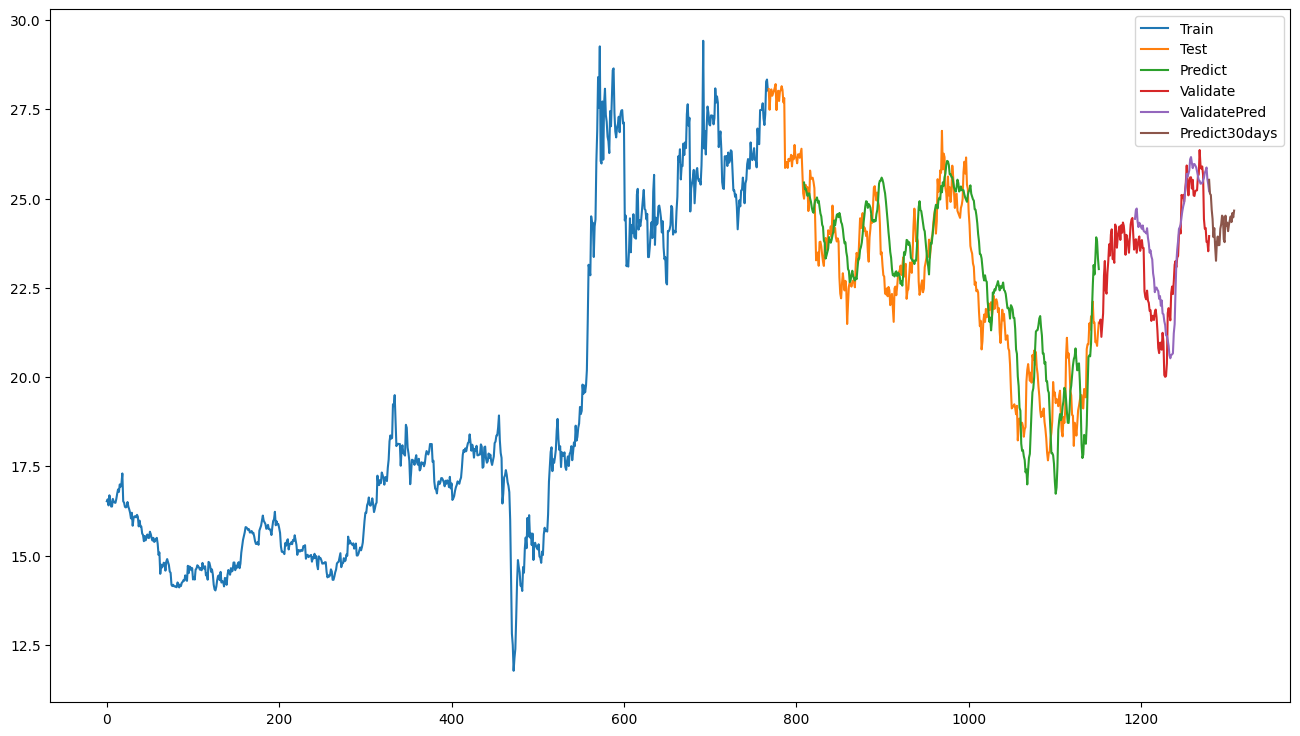

In [19]:
# Vẽ hình
plt.figure(figsize=(16,9))

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(train_data_index,train_data_df)

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, test_data_df)

test_data_index = pd.RangeIndex(start=train_size+ 41, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred_test)

val_data_index = pd.RangeIndex(start=train_size + test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index, val_data_df)

val_data_index = pd.RangeIndex(start=train_size + test_size+ 41, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)


prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)
plt.plot(prediect_data_index,next30days_predict_inverse)
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [20]:
from tensorflow.keras.utils import plot_model
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 1, 38, 256)       1024      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 1, 19, 256)       0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 17, 128)       98432     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 1, 8, 128)        0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 1, 6, 64)         2